In [6]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain.agents import  initialize_agent, tool
from langchain_community.tools import TavilySearchResults
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver #persistence
# unique ids for each user session
from uuid import uuid4 
import json

load_dotenv()
# add_messages = reducer method, to update the graph state
# model = ChatOpenAI(model="gpt-4o")
model = ChatGoogleGenerativeAI(model='gemini-2.0-flash-001')

In [10]:
# testing all env variables
search_tool = TavilySearchResults(max_results=4)

tools = [search_tool]

memory = MemorySaver() # introduces persistence in our chat application

# search_tool.invoke('which day is today')

In [12]:
# llm instance to have access to these tools
llm_with_tools = model.bind_tools(tools=tools)

In [ ]:
llm_with_tools.invoke('which day is today')

AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "current date"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--8deaaf41-1aeb-4983-99ed-75e449d9deb9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current date'}, 'id': 'f9803083-3ec7-446e-a8a9-c2f0994ac8eb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 53, 'output_tokens': 11, 'total_tokens': 64, 'input_token_details': {'cache_read': 0}})

In [18]:
a = llm_with_tools.invoke('which day is today')
print(a.content)

In [ ]:
a = llm_with_tools.invoke('which day is today')
print(a)         # dumps the entire object
# print(dir(a))    # see available attributes/methods


content='' additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "current date"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []} id='run--ffefeb43-6ace-4969-85e2-8672ba63652a-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current date'}, 'id': '397146aa-383e-4634-bdf7-abd4009d5f77', 'type': 'tool_call'}] usage_metadata={'input_tokens': 53, 'output_tokens': 11, 'total_tokens': 64, 'input_token_details': {'cache_read': 0}}


### content: 
✅ Key insight for working with LangGraph

>LLM output may be empty if a tool is called. Always check tool_calls.

>Use .last_message_text() or iterate messages to extract textual content.

> Tool calls are stored in tool_calls and additional_kwargs.

>Metadata (response_metadata & usage_metadata) is useful for debugging and cost tracking but not for the answer itself.

### Attributes / Methods (dir(a))

Many methods come from Pydantic models, because LangGraph wraps messages in Pydantic classes.

Important ones for extracting content:

>content → text directly generated (empty if a tool was called)

>tool_calls → details about any tools invoked

>additional_kwargs → extra instructions to tools

>last_message_text() → method that often returns the final text result

>messages → list of AIMessage objects (sometimes nested)

In [21]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    # annotated allows you to add extra metadata
    messages: Annotated[list, add_messages] # reducer function (update the state)

# lot of concurrent users, u dont want to block the thread in production
# 1st node = model node
async def model(state: State): # function is asynchronous
    result = await llm_with_tools.ainvoke(state["messages"]) 
    # updates the state
    return {
        "messages": [result], 
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]
# if it has tool calls its gonna route the flow 2 the tool node
    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    
    # Initialize list to store tool messages
    tool_messages = []
    
    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"] # internet search query located
        tool_id = tool_call["id"]
        
        # Handle the search tool
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)
            
            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
    
    # Add the tool messages to the state
    return {"messages": tool_messages}

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)


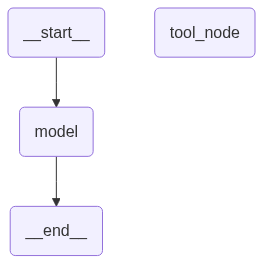

In [22]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [ ]:
config = {
    "configurable": {
        "thread_id": 5
    }
}

response = await graph.ainvoke({ # will give data abruptly
    "messages": [HumanMessage(content="When is the next spaceX launch?")], 
}, config=config)

response

{'messages': [HumanMessage(content='When is the next spaceX launch?', additional_kwargs={}, response_metadata={}, id='cf19c232-a9e5-4847-877a-bde9386da089'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "next SpaceX launch"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--aa35d406-a438-42e2-a89f-42b251885541-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'next SpaceX launch'}, 'id': '64c5df89-efdd-40c0-8eb9-53de7c3c1f0a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 12, 'total_tokens': 69, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="ClientConnectorCertificateError(ConnectionKey(host='api.tavily.com', port=443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None), SSLCertVerific

In [25]:
config = {
    "configurable": {
        "thread_id": 8
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events({
    "messages": [HumanMessage(content="When is the next spacex launch?")],
}, config=config, version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'b15ca07e-d98c-44ae-b2fd-186c6ae6e12d', 'metadata': {'thread_id': 8}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={}, id='2884a04b-3d61-4c5d-b638-c1af74b50817')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': '5fe473b0-29f7-4557-b213-dc2744819c07', 'metadata': {'thread_id': 8, 'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:61495f99-aa6f-ac42-7f6e-033dc65cd284'}, 'parent_ids': ['b15ca07e-d98c-44ae-b2fd-186c6ae6e12d']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='When is the next spa

In [27]:
config = {
    "configurable": {
        "thread_id": 8
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events({
    "messages": [HumanMessage(content="When is the next spacex launch?")],
}, config=config, version="v2"):
    if event['event'] == "on_chat_model_stream":
        print(event['data']['chunk'].content, end='', flush=True)

I encountered an error when trying to retrieve information about the next SpaceX launch. The error indicates an issue with certificate verification. I will try again in case it is a temporary problem.
I am still encountering an error when trying to retrieve information about the next SpaceX launch. Please try again later.
